# **Feature importance**

We will now try to understand if the previous models are using the dataset we have composed in a explainable way. For example, we could expect that the traffic values impact a lot the air pollution.

We could also use the results to understand if the preprocessing pipeline is correct, with good choices of encodings and aggregations.

## **Data and Models Import**

As earlier,
 we load data and models

In [1]:
%load_ext autoreload
%autoreload 2

import shap
from datetime import datetime

from utils import *


datasets_folder = './datasets'
models_folder = './models'
figsize = (20,4)
verbosity = 0

tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
pollution_data = read_and_preprocess_dataset(datasets_folder, 'pollution', v=verbosity)
traffic_data = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity, radius=2)
weather_data = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

stations = list(pollution_data.keys())
agents = list(set(agent for station in stations for agent in pollution_data[station].keys()))

In [3]:
station_data = {}
station_dists = {}
date_encoding = 'radial_months-sin-cos_days_hours'

for station in stations:
    station_data[station], station_dists[station] = prepare_station_data_for_training(
        pollution_data[station], 
        traffic_data[station], 
        weather_data, 
        encoding_method=date_encoding,
        # weather merging parameters:
        aggregations = DEFAULT_AGGREGATIONS,
        max_min_columns = DEFAULT_MAX_MIN_COLUMNS, 
        # traffic merging parameters:
        bin_size = 3,
        offset = 0
    )
    
    print(f'Station {station} agents: ',', '.join(list(station_data[station].keys())))

n_hour_features = len(station_data['GIARDINI MARGHERITA']['NO2'].columns) - 1 # -1 because Agent_value is the target
n_daily_features = len(station_data['GIARDINI MARGHERITA']['PM2.5'].columns) - 1 # -1 because Agent_value is the target
print(f'Total number of hourly features: {n_hour_features}')
print(f'Total number of daily features: {n_daily_features}')

Station GIARDINI MARGHERITA agents:  NO2, O3, PM10, PM2.5
Station PORTA SAN FELICE agents:  C6H6, CO, NO2, PM10, PM2.5
Station VIA CHIARINI agents:  NO2, O3, PM10
Total number of hourly features: 24
Total number of daily features: 33


In [4]:
train_split_date = datetime(2023,12,31,23)
target = 'Agent_value'

train_sets = {}
test_sets = {}

for station in stations:
    train_sets[station] = {}
    test_sets[station] = {}
    for agent in station_data[station].keys():
        train_sets[station][agent] = {}
        test_sets[station][agent] = {}

        x_train, y_train, x_test, y_test = create_train_test(station_data[station][agent], train_split_date, y=target)

        train_sets[station][agent]['x'] = x_train
        train_sets[station][agent]['y'] = y_train
        test_sets[station][agent]['x'] = x_test
        test_sets[station][agent]['y'] = y_test

Load the models saved while training in [agents estimation notebook](./6-agents-estimations.ipynb).

In [5]:
models = load_models(models_folder)

Loading model: GIARDINI MARGHERITA.NO2
Loading model: GIARDINI MARGHERITA.O3
Loading model: GIARDINI MARGHERITA.PM10
Loading model: GIARDINI MARGHERITA.PM2_5
Loading model: PORTA SAN FELICE.C6H6
Loading model: PORTA SAN FELICE.CO.json
Loading model: PORTA SAN FELICE.NO2
Loading model: PORTA SAN FELICE.PM10
Loading model: PORTA SAN FELICE.PM2_5
Loading model: VIA CHIARINI.NO2.json
Loading model: VIA CHIARINI.O3
Loading model: VIA CHIARINI.PM10.pkl


## **Explainability with Permutation Importance**

First, we will try a simple permutation importance.

In [6]:
from sklearn.inspection import permutation_importance

agents_permutation_importance = {}

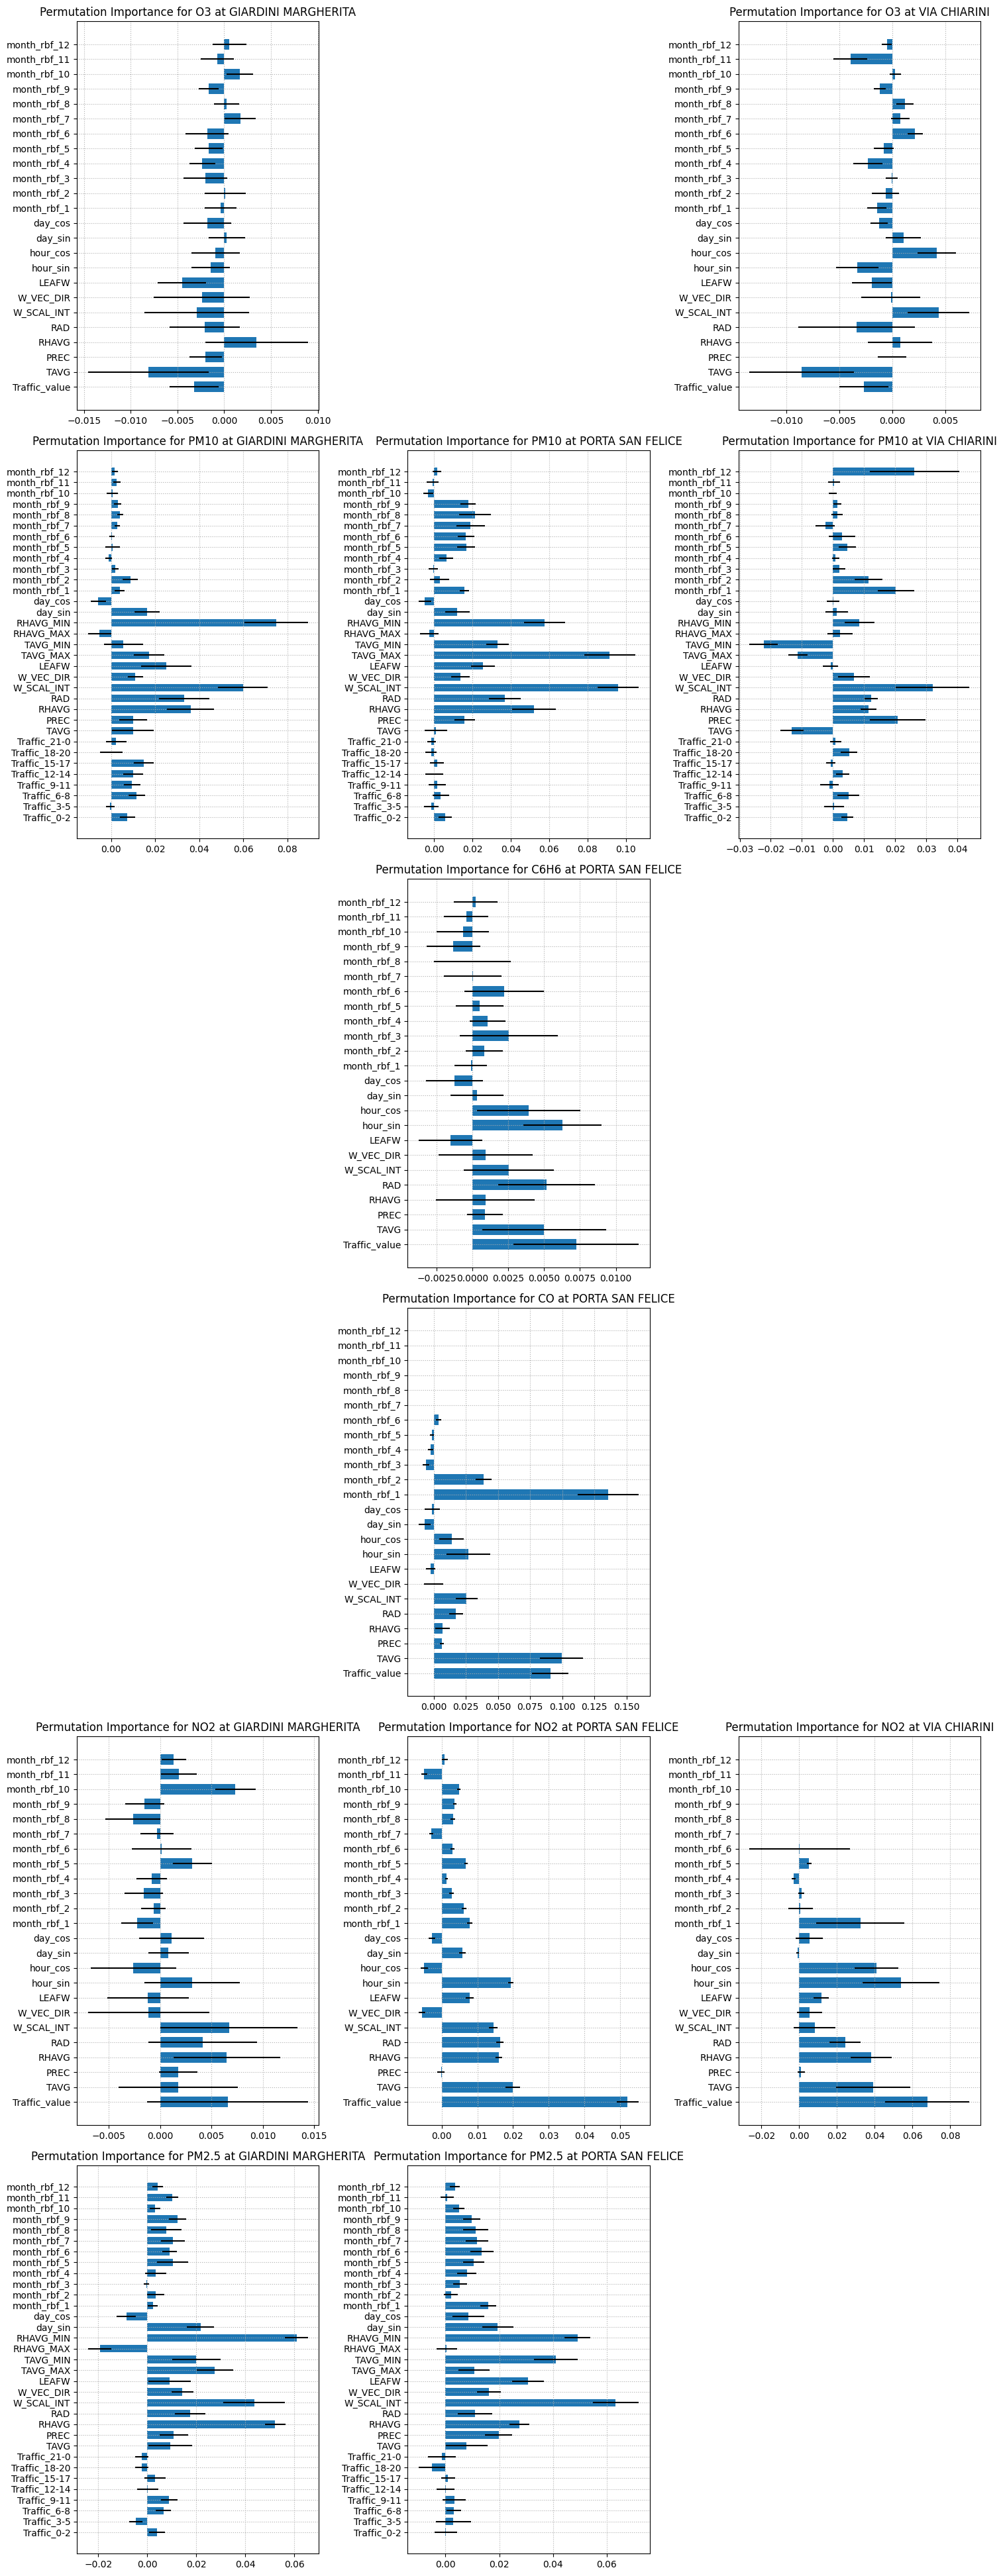

In [7]:
from sklearn.metrics import mean_absolute_error


def neg_mae_scorer(model, X, y):
    try:
        y_pred = model.predict(X, verbose=0)
    except: # sklearn doesnt have `verbose`
        y_pred = model.predict(X)
    return -mean_absolute_error(y, y_pred)

def lstm_neg_mae_scorer(model, x, y, time_steps, n_features):
    x = x.reshape(-1, time_steps, n_features) # since that this is getting used by permutation_importance, it gets 2d data as input and needs to be reshaped
    y_pred = model.predict(x, verbose=0)
    return -mean_absolute_error(y, y_pred)


n_samples = 100 
n_repeats = 10

n_rows = len(agents)
n_cols = len(stations)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 6.5))

for station in stations:
    if station not in agents_permutation_importance:   
        agents_permutation_importance[station] = {}
    for agent in models[station].keys():
        model = models[station][agent]
        X_test = test_sets[station][agent]['x']
        y_test = test_sets[station][agent]['y']
        features = X_test.columns
        importances = {}
        scoring = neg_mae_scorer
        seqs = False
        input_shape=None

        if isinstance(model, tf.keras.models.Sequential):
            input_shape = model.input_shape
            
            if len(input_shape) == 2: #ffnn
                pass
                
            if len(input_shape) == 3: # seqs or cnn
                seqs = True
                time_steps = input_shape[1] 
                n_features = input_shape[2] 
                use_mask = isinstance(model.layers[0], tf.keras.layers.Masking)
                X_test, y_test = create_sequences(test_sets[station][agent]['x'], test_sets[station][agent]['y'], time_steps, use_mask=use_mask)
                y_test = y_test.to_numpy()
                test_data_idx = np.random.choice(X_test.shape[0], size=n_samples, replace=False)
                X_test = X_test[test_data_idx]
                y_test = y_test[test_data_idx]
                X_test = X_test.reshape(X_test.shape[0], -1) # permutation_importance does not allow for 3d data

                scoring = lambda model, x, y: lstm_neg_mae_scorer(model, x, y, time_steps, n_features) # lambda because we had to pass time steps and num. features    
            
        else: # other models
            X_test = X_test.sample(n_samples, random_state=42)
            y_test = y_test.sample(n_samples, random_state=42)

        # print(f'Computing importance for {station} {agent}')

        # compute importances
        importances_result = permutation_importance(model,
                                                    X_test,
                                                    y_test,
                                                    scoring=scoring,
                                                    n_repeats=n_repeats,
                                                    random_state=42)
        
        for key in ('importances_mean', 'importances_std'): # we don't care about the full repetitions values (`importances`)
            val = importances_result[key]
            if seqs: # for the seqs we had to flatten the sequences, now we have one ts*n_feat. total features, so we go back to the original shape averaging
                val = val.reshape(input_shape[1], input_shape[2])
                val = val.mean(axis=0)
            importances[key] = val

        # save the importances
        agents_permutation_importance[station][agent] = importances

        # plot
        ax = axes[agents.index(agent)][stations.index(station)]
        ax.barh(features, importances['importances_mean'], height=0.7, xerr=importances['importances_std'])
        ax.set_title(f'Permutation Importance for {agent} at {station}')
        ax.grid(linestyle=':')

for station in stations:
    for agent in agents:
        if agent not in models[station]:
            axes[agents.index(agent)][stations.index(station)].axis('off') # remove unused subplots

plt.tight_layout()
plt.show()

From the previous plot we can extract the following insights:
- PM2.5 and PM10: most of the importance comes from weather features (temperature humidity and wind). Traffic and month encodings usually have minimal effect on accuracy
- C6H6: the importance scores are relatively uniform across all features, suggesting that the model does not rely heavily on any single variable
- CO: month, traffic and average temperature have a big impact on model's accuracy
- O3: average temperature is the most critical feature. Its permutation leads to a big drop in model performance, while the other features have smaller contribute
- NO2: feature importance varies substantially between stations:
    - at Via Chiarini, the model heavily uses traffic informations
    - at Giardini Margherita, the model is only mildly sensitive to feature permutations, indicating less specific feature reliance.
    - at Porta San Felice, weather-related features have the largest impact on accuracy

## **Explainability with SHAP**

Now we test also using shapely values to check if the previous conclusions are confirmed.

In [8]:
agents_shap_values = {}

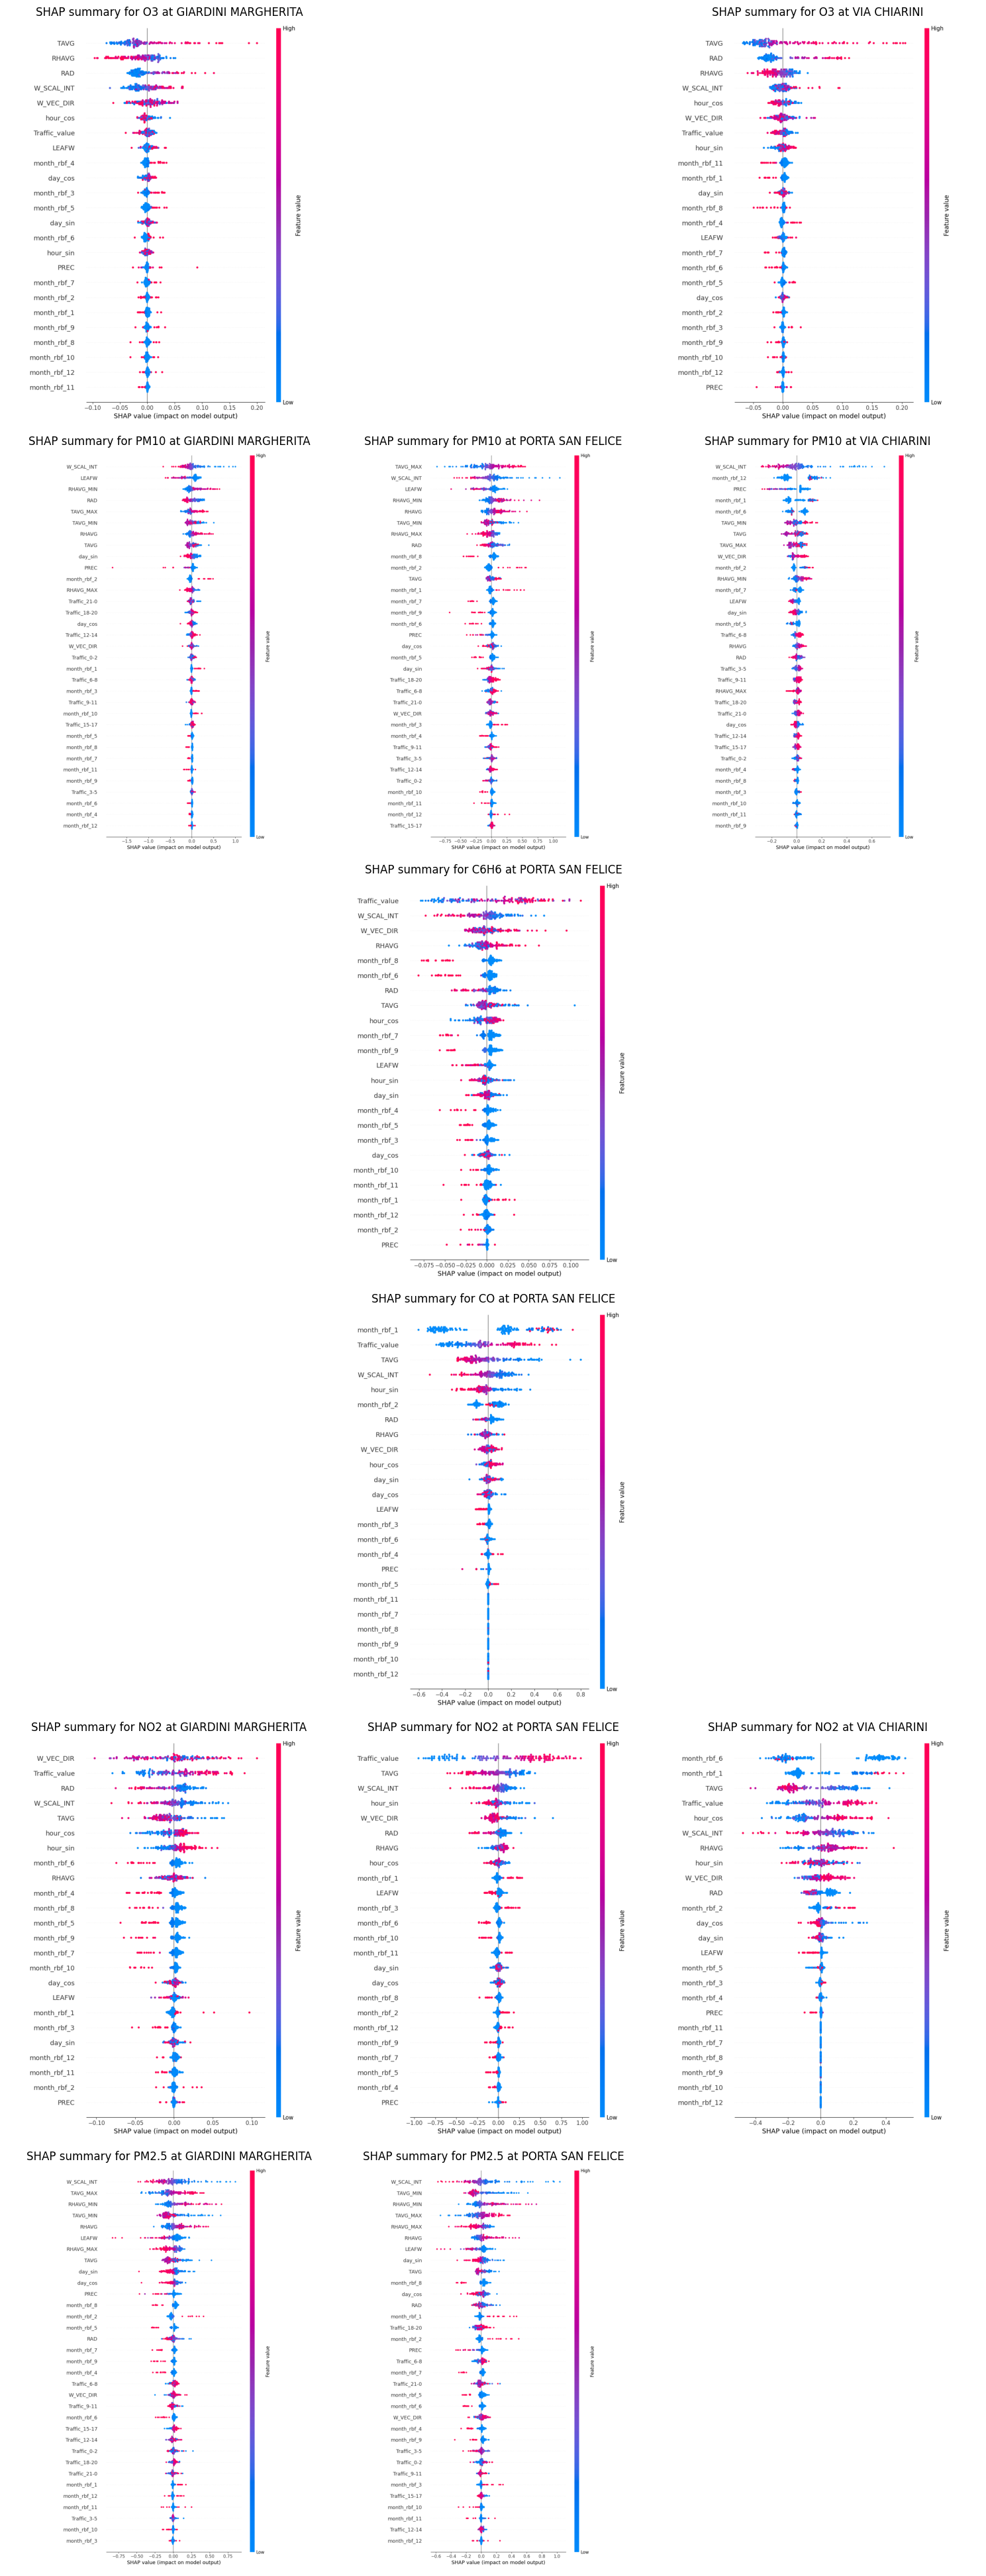

In [53]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import warnings

# shap raises this warning
warnings.filterwarnings(
    "ignore",
    message="`tf.keras.backend.set_learning_phase` is deprecated",
    category=UserWarning,
    module="keras.backend"
)


def model_predict(data): # used in kernel explainers
    return model.predict(data,verbose=0).reshape(-1) # with no reshaping it does not work

n_samples = 150

n_rows = len(agents)
n_cols = len(stations)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 6.5))

for station in stations:
    if station not in agents_shap_values:   
        agents_shap_values[station] = {}
    for agent in models[station].keys():
        model = models[station][agent]
        if isinstance(model, tf.keras.models.Sequential):
            training_data = None
            test_data = None
            shap_values = None
            input_shape = model.input_shape

            if len(input_shape) == 2: # ffnn
                training_data = train_sets[station][agent]['x'].sample(n_samples, random_state=42)
                test_data = test_sets[station][agent]['x'].sample(n_samples, random_state=42)
                
                # kernel (has to predict and becomes so slow with many samples)
                # explainer = shap.KernelExplainer(model_predict, training_data)
                # shap_values = explainer.shap_values(test_data)

                # gradient
                explainer = shap.GradientExplainer(model, training_data)
                shap_values = explainer.shap_values(np.array(test_data))
                shap_values = shap_values.squeeze()

            if len(input_shape) == 3: # lstm or cnn
                time_steps = input_shape[1] 
                use_mask = isinstance(model.layers[0], tf.keras.layers.Masking)
                training_data, _ = create_sequences(train_sets[station][agent]['x'], train_sets[station][agent]['y'], time_steps, use_mask=use_mask)
                test_data, _ = create_sequences(test_sets[station][agent]['x'], test_sets[station][agent]['y'], time_steps, use_mask=use_mask)
                # training_data, _ = create_sequences(train_sets[station][agent]['x'].iloc[:3*n_samples], train_sets[station][agent]['y'].iloc[:3*n_samples], time_steps, use_mask=use_mask)
                # test_data, _ = create_sequences(test_sets[station][agent]['x'].iloc[:3*n_samples], test_sets[station][agent]['y'].iloc[:3*n_samples], time_steps, use_mask=use_mask)
                
                # if you sample before creating the sequences you would separate consecutive values. We might want to sample groups of time_steps elements
                # and then create sequences with no sliding window. Or simply shrinken the dataset before, you need num_samples + time_steps -1 hours in total,
                # so maybe keep 2/3 times num_samples before creating sequences <-- currenty doing this (missing the first `times_steps` -1 elements)
                training_data_idx = np.random.choice(training_data.shape[0], size=n_samples, replace=False)
                test_data_idx = np.random.choice(test_data.shape[0], size=n_samples, replace=False)
                training_data = training_data[training_data_idx]
                test_data = test_data[test_data_idx]

                # gradient
                explainer = shap.GradientExplainer(model, training_data)
                shap_values = explainer.shap_values(test_data)
                shap_values = np.mean(np.squeeze(shap_values), axis=1)
                test_data = pd.DataFrame(test_data.mean(axis=1), columns=test_sets[station][agent]['x'].columns)

                # kernel (might work if passed time averaged data)
                # explainer = shap.KernelExplainer(model_predict, training_data)
                # shap_values = explainer.shap_values(test_data.reshape(test_data.shape[0], -1))
                # shap_values = explainer.shap_values(test_data)

        elif isinstance(model, (RandomForestRegressor, xgb.XGBRegressor)):
            explainer = shap.TreeExplainer(model)
            test_data = test_sets[station][agent]['x'].sample(n_samples, random_state=42)
            shap_values = explainer.shap_values(test_data)

        elif isinstance(model, (xgb.XGBRegressor,)):
            training_data = shap.sample(train_sets[station][agent]['x'], n_samples, random_state=42)
            test_data = test_sets[station][agent]['x'].sample(n_samples, random_state=42)
            
            f = lambda x: model.predict(x)
            explainer = shap.KernelExplainer(f, training_data, link='logit')
            shap_values = explainer.shap_values(test_data)

        # remove outliers 
        # z_scores = np.abs((shap_values - shap_values.mean(axis=0)) / shap_values.std(axis=0))
        # shap_values = shap_values[(z_scores < 3).all(axis=1)]
        # test_data = test_data[(z_scores < 3).all(axis=1)]
        
        # save the shap values
        agents_shap_values[station][agent] = {
            'shap_values': shap_values,
            'explainer':  explainer
        }

        # plot
        ax = axes[agents.index(agent)][stations.index(station)]
        tmp_fig, tmp_ax = plt.subplots(figsize=(5, 4))
        shap.summary_plot(shap_values,
                          test_data,
                          max_display=999,
                          show=False,
                          color_bar=True,
                          rng=42
                          )
        canvas = FigureCanvas(tmp_fig)
        canvas.draw()

        # Convert canvas to image
        image = np.frombuffer(canvas.buffer_rgba(), dtype='uint8')
        image = image.reshape(tmp_fig.canvas.get_width_height()[::-1] + (4,))

        # Show the image on the target subplot
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f'SHAP summary for {agent} at {station}')

        plt.close(tmp_fig)

for station in stations:
    for agent in agents:
        if agent not in models[station]:
            axes[agents.index(agent)][stations.index(station)].axis('off') # remove unused subplots
plt.tight_layout()
plt.show()

Looking at the plots for SHAP, basically every conclusion drawn before is respected. There are little changes for some combinations of station-agents but those can be due to the chosen subset of data. The main detected behavior is the same.

Anyways, some feature plot seems strange, creating agglomerates with no clear importance distribution. For example, `hour_sin` of $NO_2$ model contributes positively to the prediction, indpendently of its magnitude. The same also occurs in other models.

### **SHAP Heatmap**

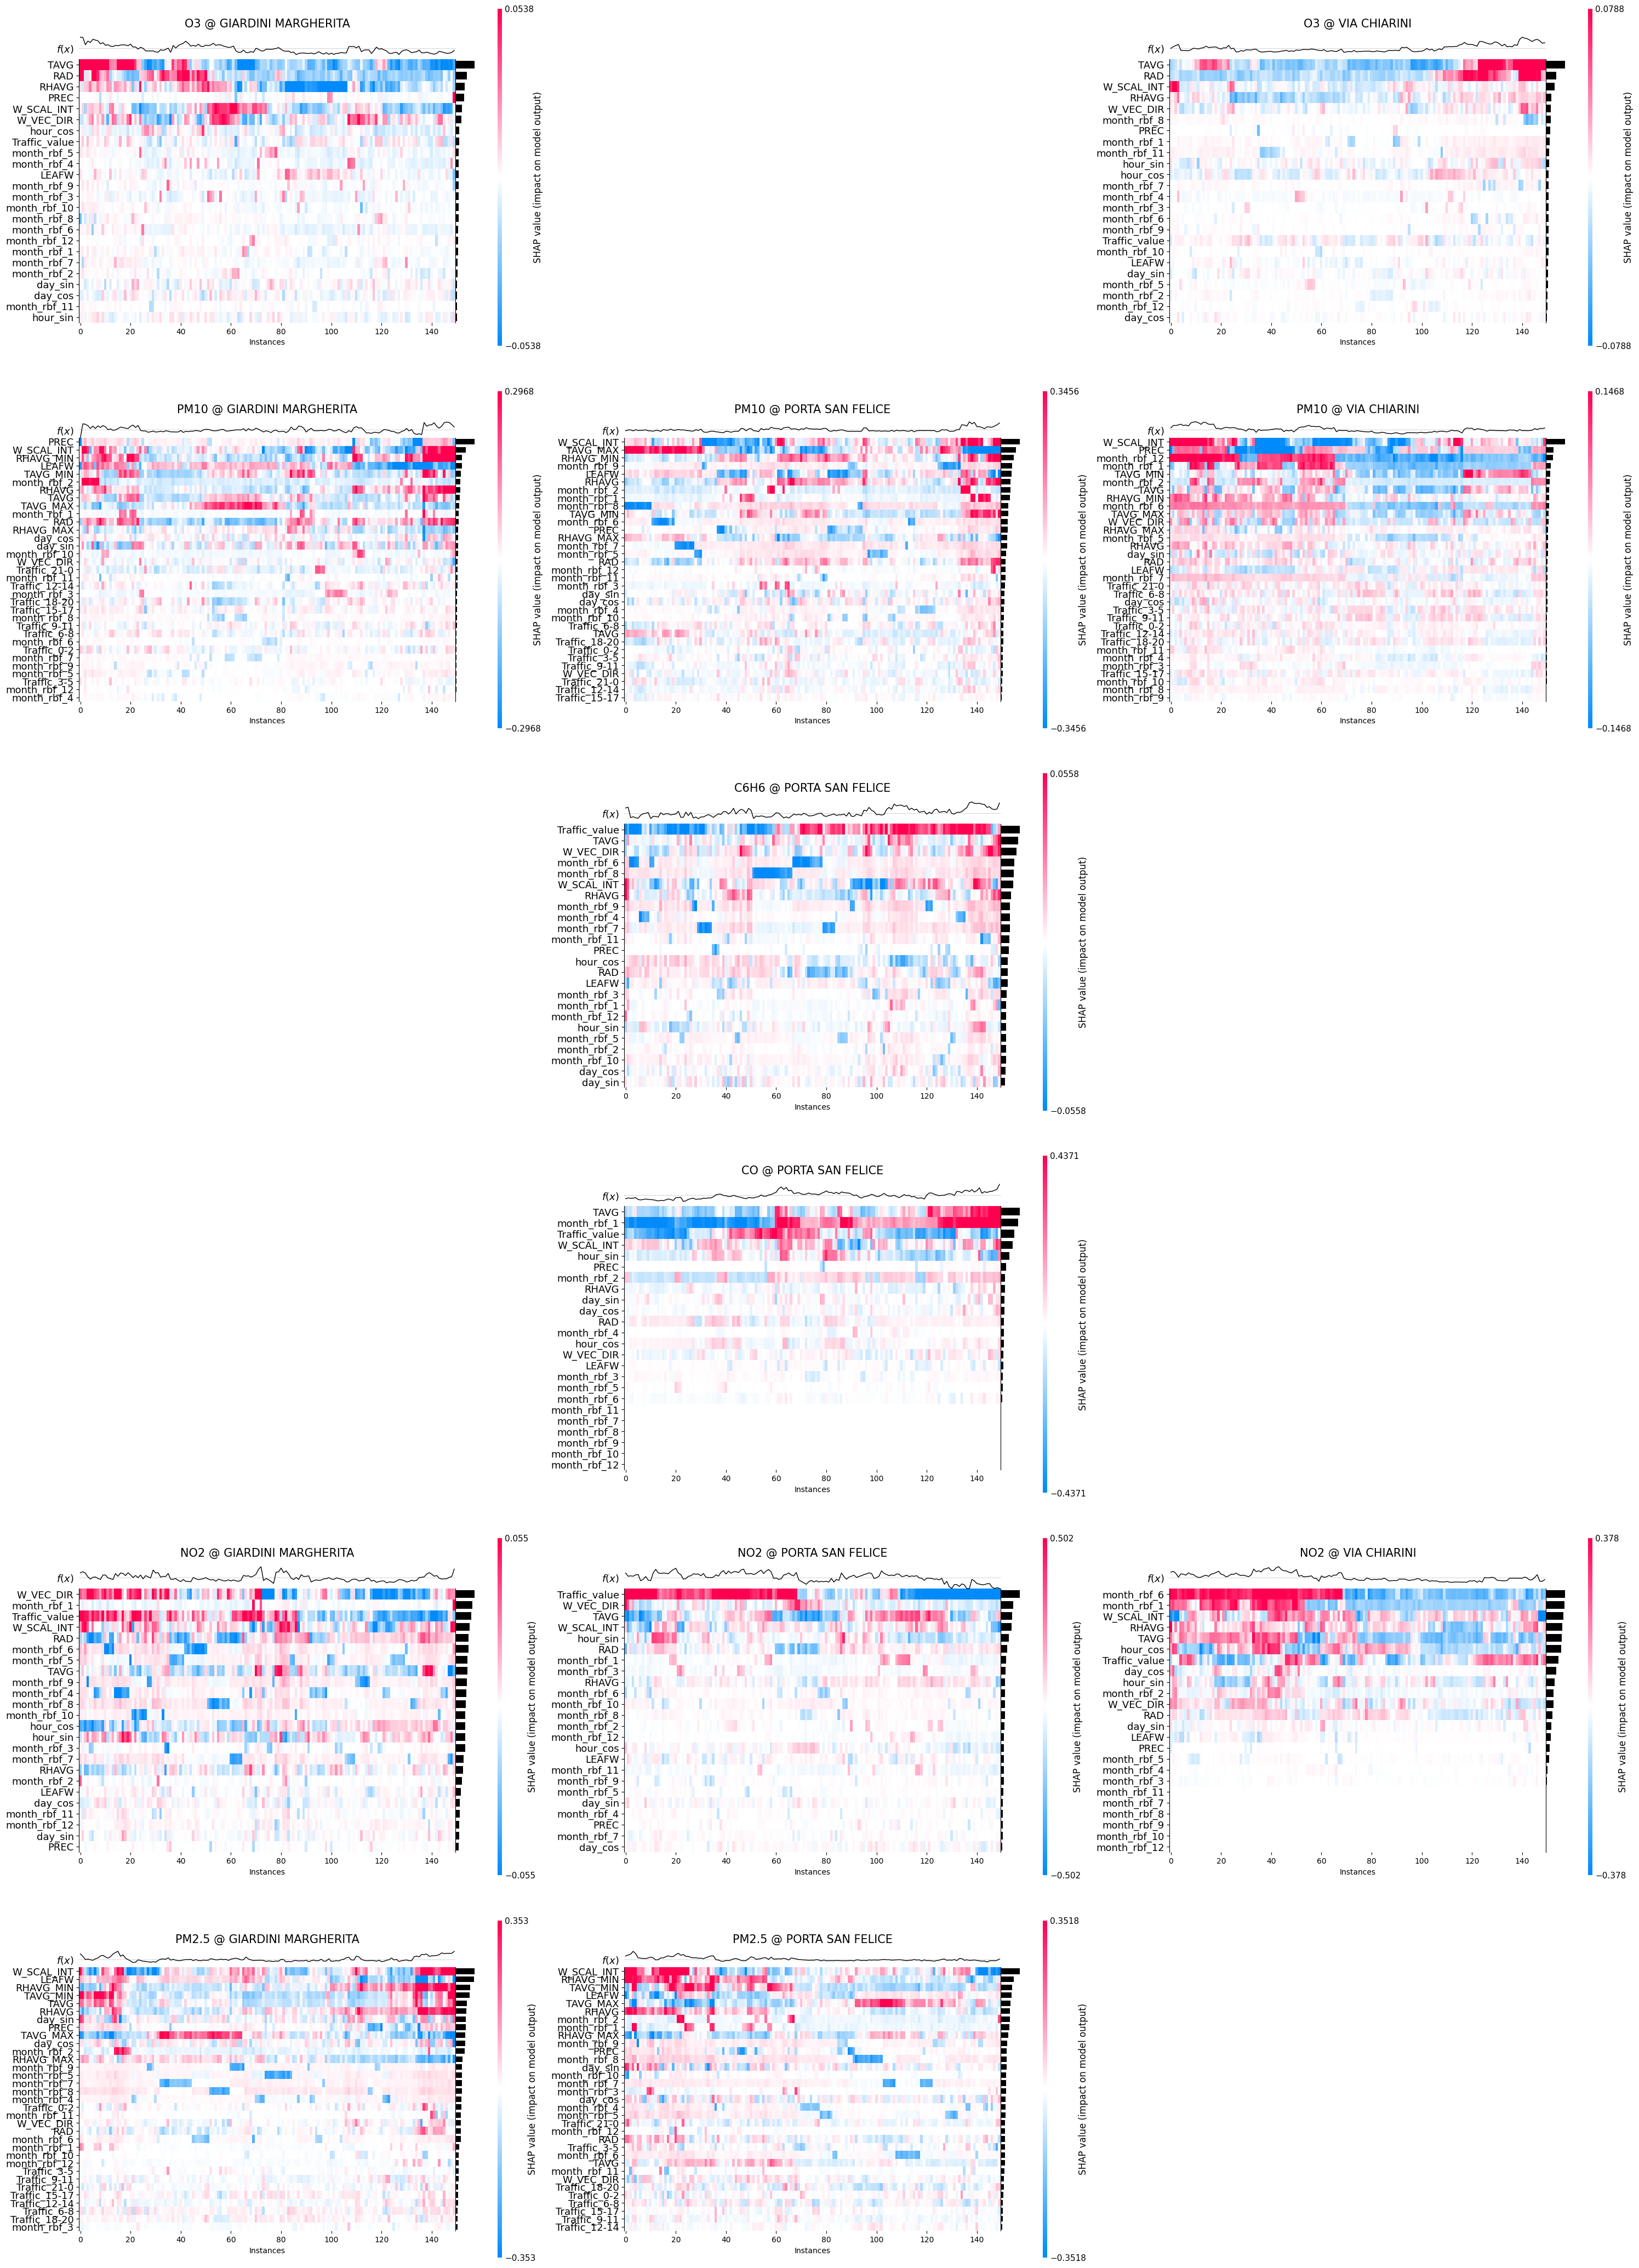

In [55]:
n_rows = len(agents)
n_cols = len(stations)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 10, n_rows * 7))
try:
    for station in stations:
        for agent in agents_shap_values[station]:
            explanation = shap.Explanation(
                values=agents_shap_values[station][agent]['shap_values'],
                data=test_sets[station][agent]['x'],
                feature_names=test_sets[station][agent]['x'].columns.tolist()
            )
            # Draw to canvas and convert to image
            ax = axes[agents.index(agent)][stations.index(station)]
            shap.plots.heatmap(
                explanation, 
                feature_values=explanation.abs.max(0), 
                max_display=40,
                plot_width=10,
                show=False,
                ax=ax
            )
            ax.set_title(f"{agent} @ {station}", fontsize=15)
except IndexError as e:
    pass

for station in stations:
    for agent in agents:
        if agent not in models[station]:
            axes[agents.index(agent)][stations.index(station)].axis('off') # remove unused subplots
plt.tight_layout()
plt.show()

From the heatmaps, we can notice that almost all the influential features alternate between large negative and large positive SHAP values. This indicates that, depending on the instance, the same feature can either increase or decrease the predicted pollutant concentration. 

The impact of a feature is context-dependent, meaning its effect varies based on the values of other features and the specific conditions present in each instance. 

This alternating pattern reflects the nonlinear nature of the underlying model.

### **SHAP Bars**

577it [00:11,  4.68it/s]                         
577it [00:12,  7.75it/s]                         
1090it [00:12, 15.62it/s]                          


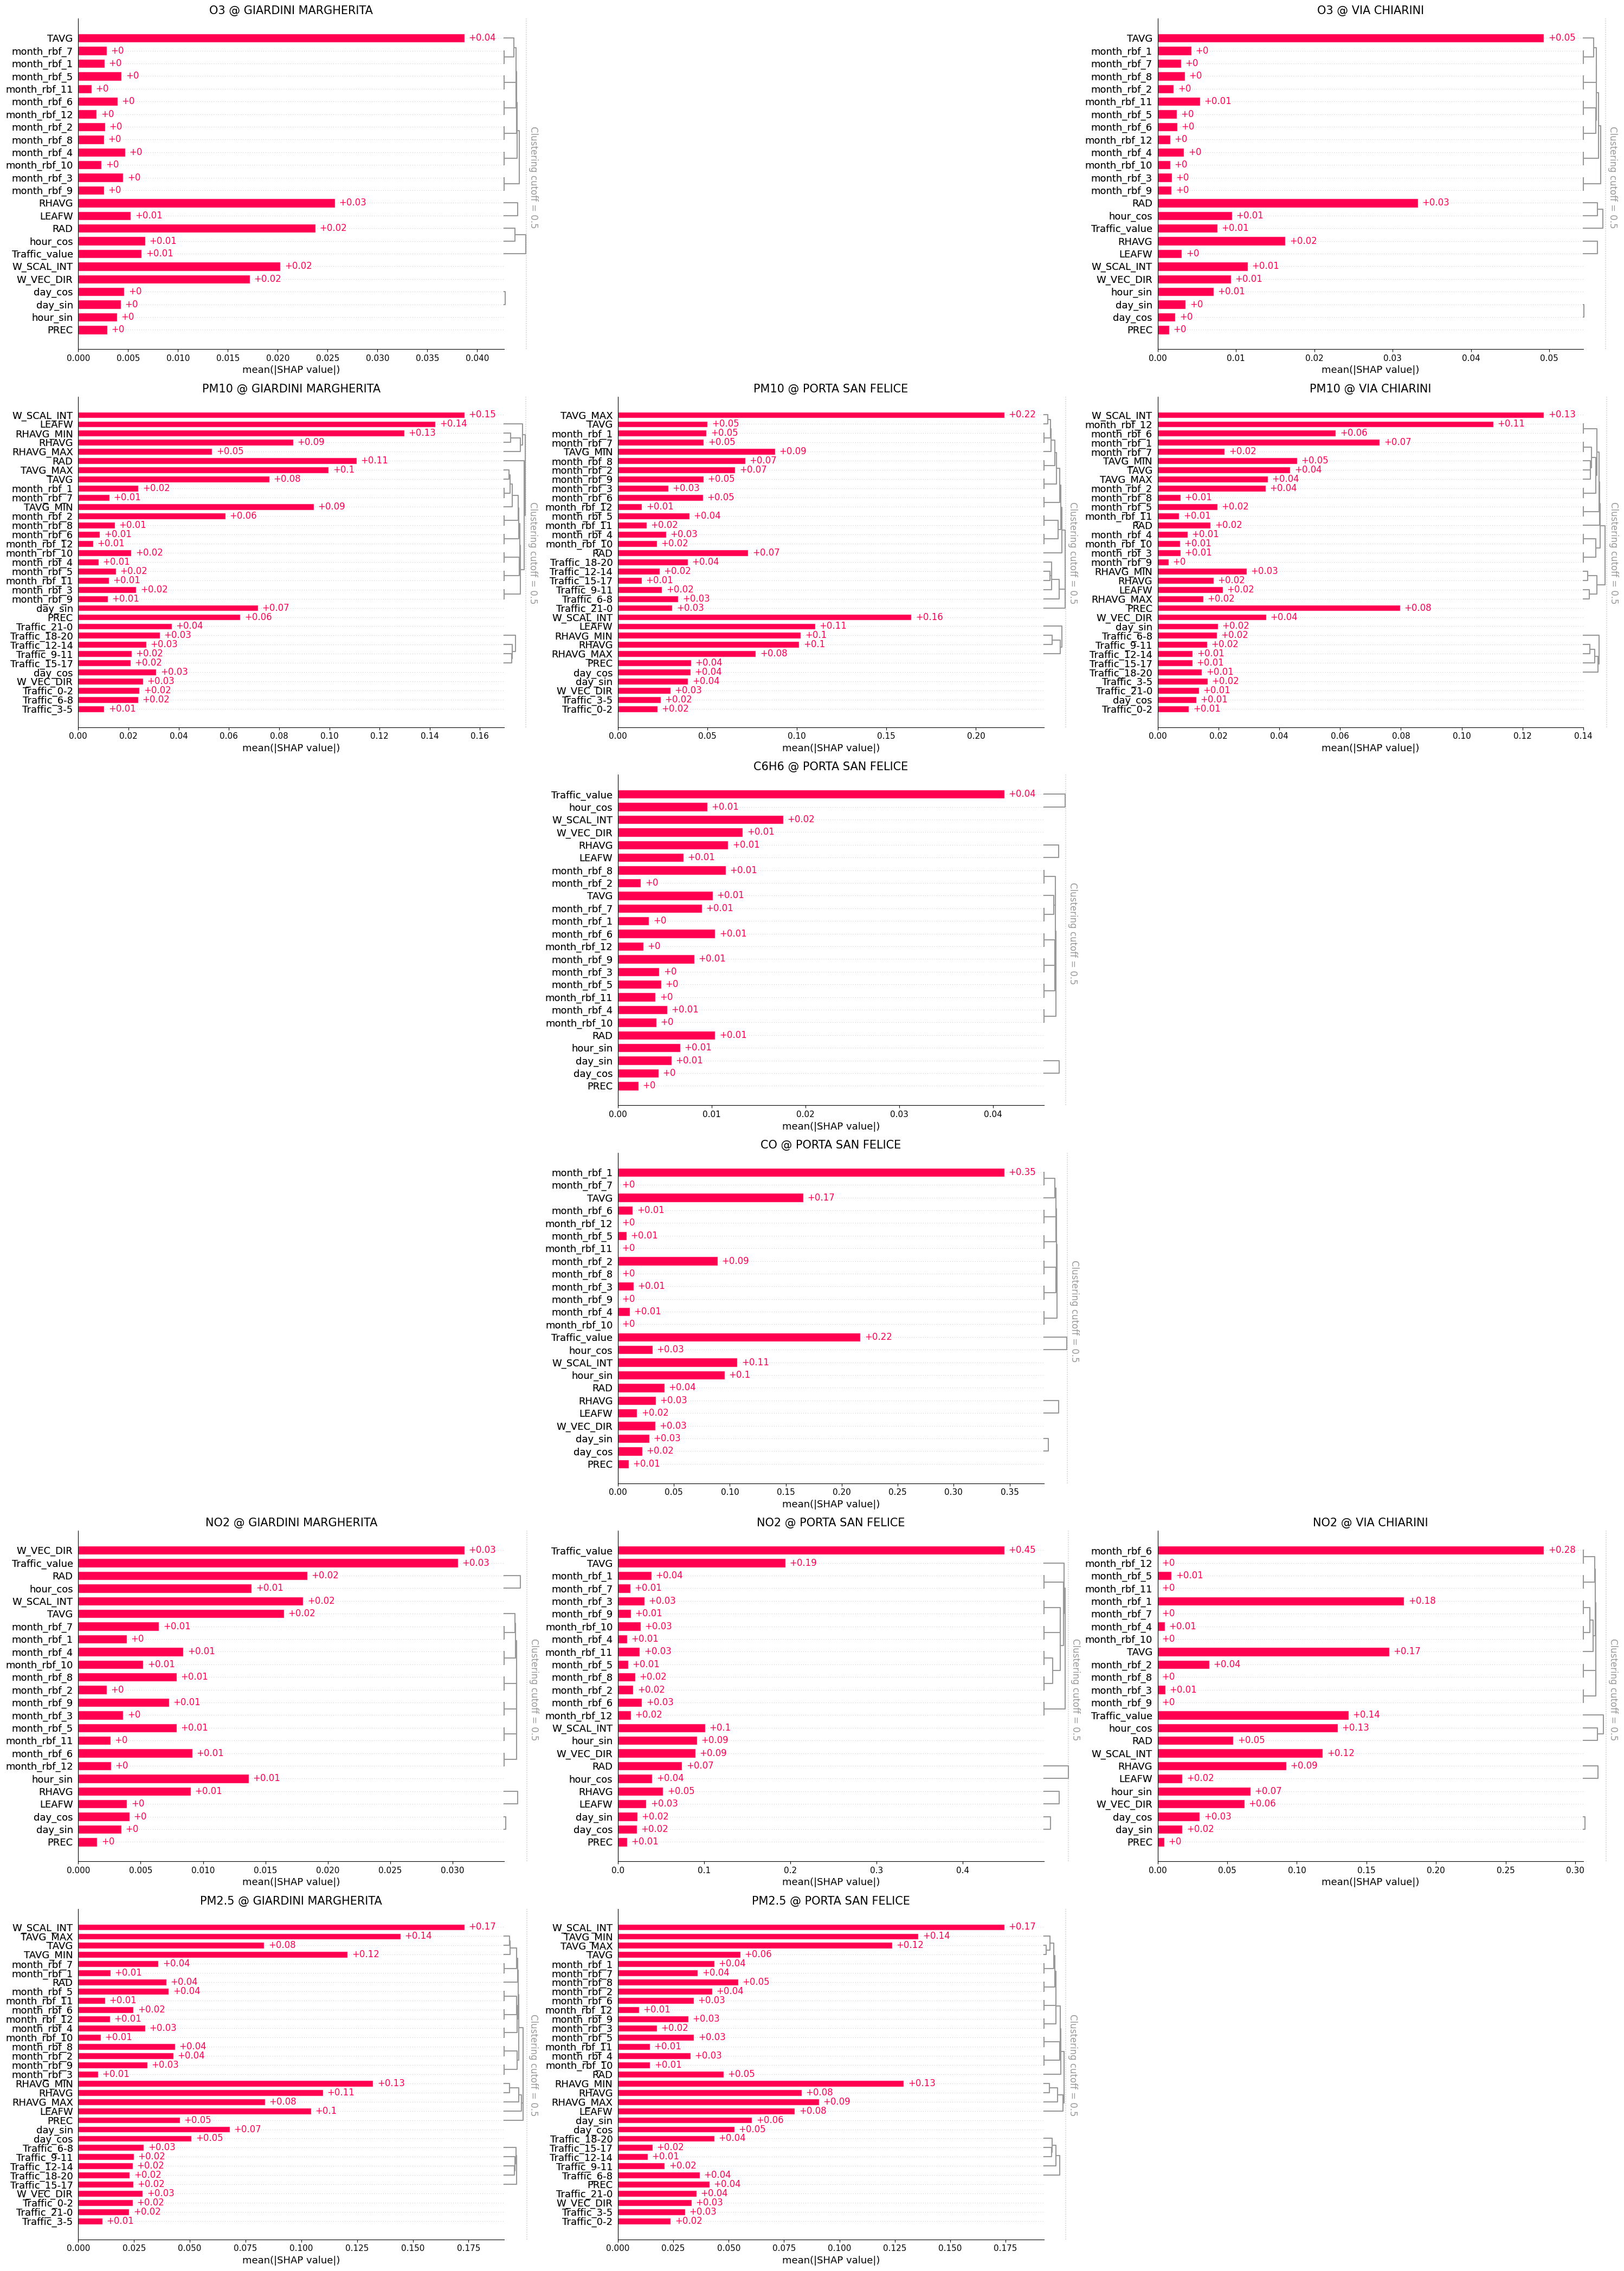

In [56]:
n_rows = len(agents)
n_cols = len(stations)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 10, n_rows * 7))

for station in stations:
    for agent in agents_shap_values[station]:
        explanation = shap.Explanation(
            values=agents_shap_values[station][agent]['shap_values'],
            data=test_sets[station][agent]['x'],
            feature_names=test_sets[station][agent]['x'].columns.tolist()
        )
        clustering = shap.utils.hclust(test_sets[station][agent]['x'], test_sets[station][agent]['y'])
        # Draw to canvas and convert to image
        ax = axes[agents.index(agent)][stations.index(station)]
        shap.plots.bar(
            explanation, 
            clustering=clustering, 
            clustering_cutoff=0.5,
            max_display=40,
            show=False,
            ax=ax
        )
        ax.set_title(f"{agent} @ {station}", fontsize=15)

        
for station in stations:
    for agent in agents:
        if agent not in models[station]:
            axes[agents.index(agent)][stations.index(station)].axis('off') # remove unused subplots
plt.tight_layout()
plt.show()

Also with the barplot we can easily see that the previous extracted insights were accurate.

> Distance in the clustering is assumed to be scaled roughly between 0 and 1, where 0 distance means the features perfectly redundant and 1 means they are completely independent

## Results

Finally we print the list of features ordered by importance.

In [57]:
shap_feature_importance = extract_ordered_features_by_shap(agents_shap_values, test_sets)
print('shap_feature_importance = {')
for station in shap_feature_importance:
    print(f"'{station}': {{")
    for agent in shap_feature_importance[station]:
        print(f"       '{agent}': [", end='')
        print(', '.join([f"'{e}'" for e in shap_feature_importance[station][agent]]),'],')
    print('    },')
print('}')

shap_feature_importance = {
'GIARDINI MARGHERITA': {
       'NO2': ['W_VEC_DIR', 'Traffic_value', 'RAD', 'W_SCAL_INT', 'TAVG', 'hour_cos', 'hour_sin', 'month_rbf_6', 'RHAVG', 'month_rbf_4', 'month_rbf_8', 'month_rbf_5', 'month_rbf_9', 'month_rbf_7', 'month_rbf_10', 'day_cos', 'LEAFW', 'month_rbf_1', 'month_rbf_3', 'day_sin', 'month_rbf_12', 'month_rbf_11', 'month_rbf_2', 'PREC' ],
       'O3': ['TAVG', 'RHAVG', 'RAD', 'W_SCAL_INT', 'W_VEC_DIR', 'hour_cos', 'Traffic_value', 'LEAFW', 'month_rbf_4', 'day_cos', 'month_rbf_3', 'month_rbf_5', 'day_sin', 'month_rbf_6', 'hour_sin', 'PREC', 'month_rbf_7', 'month_rbf_2', 'month_rbf_1', 'month_rbf_9', 'month_rbf_8', 'month_rbf_10', 'month_rbf_12', 'month_rbf_11' ],
       'PM10': ['W_SCAL_INT', 'LEAFW', 'RHAVG_MIN', 'RAD', 'TAVG_MAX', 'TAVG_MIN', 'RHAVG', 'TAVG', 'day_sin', 'PREC', 'month_rbf_2', 'RHAVG_MAX', 'Traffic_21-0', 'Traffic_18-20', 'day_cos', 'Traffic_12-14', 'W_VEC_DIR', 'Traffic_0-2', 'month_rbf_1', 'Traffic_6-8', 'month_rbf_3', 'Traf